# Лабораторная работа №3: Свойства оценок, полученных методом моментов 

**Цели и задачи л/р**:  

1. Реализовать метод моментов к равномерному распределению (в качестве
   параметров выбрать левую и правую границы распределения). Использовать в
   качестве генерального распределения равномерное распределение от 0 до 1.
   Построить график зависимости значения оценок от величины выборки.
2. Реализовать обобщенный метод  моментов к равномерному распределению (в
   качестве параметров также выбрать левую и правую границы распределения).
   Использовать в качестве генерального распределения также равномерное
   распределение от 0 до 1. Построить график зависимости значения оценок от
   величины выборки (при участии в методе 3, 5, 7 моментов).
   Предложить веса для обобщенного метода моментов, позволяющие снизить дисперсию 
   получаемых оценок по сравнению с классическим методом моментов.
3. Построить график зависимости среднеквадратического отклонения перечисленных в
   пп. 1 и 2 оценок от размера выборки. Для оценки среднеквадратического отклонения
   использовать $10^3$ выборок. Сделать выводы.
4. Выполнить пункты 1-3 для экспоненциального распределения.
   https://ru.wikipedia.org/wiki/Экспоненциальное_распределение

In [3]:
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from tqdm.contrib.concurrent import process_map

In [27]:
SAMPLE_SIZES = sorted(
    [10**p for p in range(1, 5)]
    + [3 * 10**p for p in range(1, 4)] # 3 -> nice middle on log-scaled axis
)
SAMPLE_SIZES_GMM = [100, 1000, 10000]
UNIFORM_LOW = 0
UNIFORM_HIGH = 1
N_EXPERIMENTS = 1_000
K = [3, 5, 7]
HARMONIC_POWS = [0, 2, 5]
EXP_LAMBDA = 1

In [16]:
def weights_harmonic(k, pow=1):
    return np.array([1 / j**pow for j in range(1, k + 1)])

## Метод моментов для равномерного распределения
Уравнения для вычисления моментов:
$$
\begin{cases}
\mu_1^* = \cfrac{1}{n}\sum_{i=1}^{n}x \\
\mu_2^* = \cfrac{1}{n}\sum_{i=1}^{n}x^2
\end{cases}
$$

k-я моментная функция: $\mu_k[r]=\int^{+\infty}_{-\infty}x^k\cdot\varphi_r(x, b_1, ... b_k)dx = g_k(b_1,...b_k)$

Для равномерного распределения $X \sim U_{b_1,b_2}$:
$$
\begin{cases}
\mu_1^* = \cfrac{b_1^* + b_2^*}{2}; \\
\mu_2^* = \cfrac{(b_2^*)^3 - (b_1^*)^3}{3\cdot(b_2^*-b_1^*)} = \cfrac{(b_2^*)^2 + b_2b_1 + (b_1^*)^2}{3}
\end{cases}
$$

Выразим $b_1^*$ и $b_2^*$:

$$
\begin{cases}
b_1^* = \mu_1^* - \sqrt{3\cdot\mu_2^* - 3\cdot(\mu_1^*)^2}; \\
b_2^* = \mu_1^* + \sqrt{3\cdot\mu_2^* - 3\cdot(\mu_1^*)^2}
\end{cases}



In [28]:
def uniform_moments(sample):
    m1 = np.mean(sample)
    m2 = np.mean(sample**2)

    b1 = m1 - np.sqrt(3 * m2 - 3 * m1 ** 2)
    b2 = m1 + np.sqrt(3 * m2 - 3 * m1 ** 2)

    return b1, b2

In [29]:
def experiment_uniform_mm(args):
    n, i = args
    sample = np.random.uniform(size=n, low=UNIFORM_LOW, high=UNIFORM_HIGH)
    b1, b2 = uniform_moments(sample)
    return [n, b1, b2]

In [ ]:
args_uniform = list(itertools.product(SAMPLE_SIZES, range(N_EXPERIMENTS)))
rs = process_map(experiment_uniform_mm, args_uniform, chunksize=1)

100%|██████████| 7000/7000 [00:17<00:00, 410.30it/s]


In [ ]:
df = pd.DataFrame(rs, columns=("n", "b1", "b2"))
df

,n,b1,b2
0,10,-0.033074,1.011700
1,10,-0.033074,1.011700
2,10,-0.033074,1.011700
3,10,-0.033074,1.011700
4,10,-0.033074,1.011700
...,...,...,...
6995,10000,0.003868,0.995902
6996,10000,0.000200,0.994941
6997,10000,0.002650,1.002096
6998,10000,0.001559,1.005664


In [ ]:
df.to_csv("lab-3/uniform_mm_1.csv", index=False)

In [30]:
df = pd.read_csv("lab-3/uniform_mm_1.csv")

In [31]:
df_uniform_mean = df.groupby("n").mean()
df_uniform_std = df.groupby("n").std()
sizes = df["n"].unique()

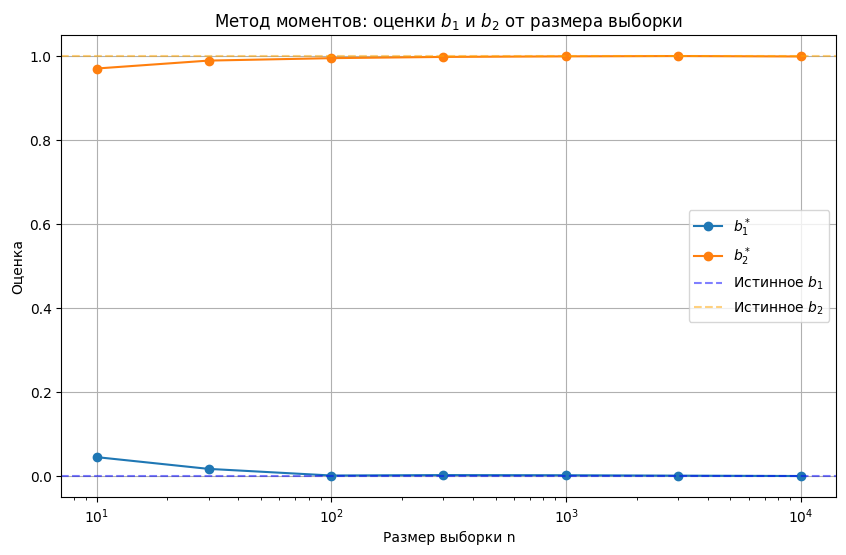

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, df_uniform_mean["b1"], marker="o", label="$b_1^*$")
plt.plot(sizes, df_uniform_mean["b2"], marker="o", label="$b_2^*$")
plt.axhline(UNIFORM_LOW, color="blue", linestyle="--", alpha=0.5, label="Истинное $b_1$")
plt.axhline(UNIFORM_HIGH, color="orange", linestyle="--", alpha=0.5, label="Истинное $b_2$")
plt.xscale("log")
plt.xlabel("Размер выборки n")
plt.ylabel("Оценка")
plt.title("Метод моментов: оценки $b_1$ и $b_2$ от размера выборки")
plt.legend()
plt.grid(True)

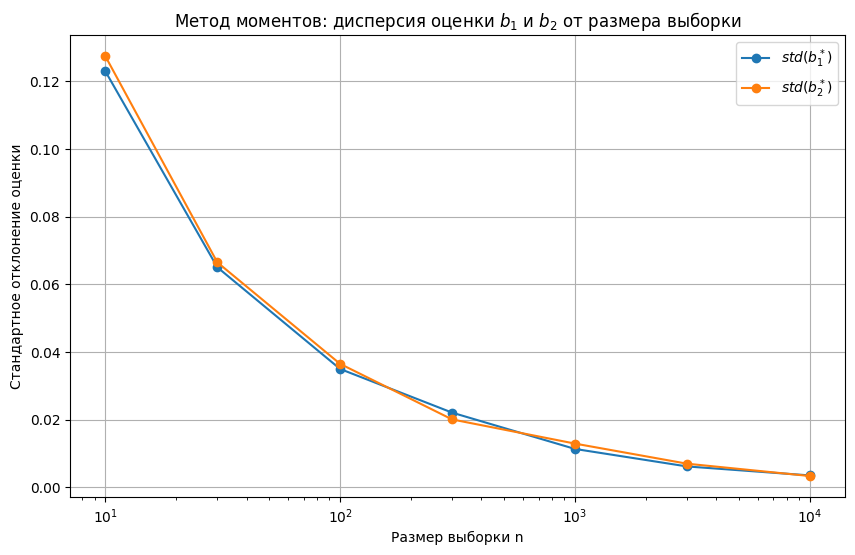

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, df_uniform_std["b1"], marker="o", label="$std(b_1^*)$")
plt.plot(sizes, df_uniform_std["b2"], marker="o", label="$std(b_2^*)$")
plt.xscale("log")
plt.xlabel("Размер выборки n")
plt.ylabel("Стандартное отклонение оценки")
plt.title("Метод моментов: дисперсия оценки $b_1$ и $b_2$ от размера выборки")
plt.legend()
plt.grid(True)

### Обобщенный метод моментов


In [34]:
def uniform_gmm(sample, k, weights):
    sample_moments = np.array([np.mean(sample ** j) for j in range(1, k + 1)])

    def loss(params):
        b1, b2 = params

        def uniform_momemnt(a, b, k):
            return (b ** (k + 1) - a ** (k + 1)) / ((k + 1) * (b - a))

        uniform_moments = np.array([uniform_momemnt(b1, b2, j) for j in range(1, k + 1)])
        return np.sum(weights * (uniform_moments - sample_moments) ** 2)

    init_params = [sample.min(), sample.max()]
    optimum = scipy.optimize.minimize(loss, init_params, method="BFGS") # method="BFGS"
    opt_params = optimum.x
    return opt_params

In [35]:
def experiment_uniform_gmm(args):
    (n, ks), hp, i = args
    sample = np.random.uniform(size=n, low=UNIFORM_LOW, high=UNIFORM_HIGH)
    params = [
        uniform_gmm(sample, k, weights=weights_harmonic(k, pow=hp))
        for k in ks
    ]
    return list(zip(ks, itertools.repeat(n), itertools.repeat(hp), [p[0] for p in params], [p[1] for p in params]))

In [ ]:
uniform_gmm_args = list(
    itertools.product(
        zip(SAMPLE_SIZES_GMM, itertools.repeat(K)), HARMONIC_POWS, range(N_EXPERIMENTS)
    )
)
pss = process_map(experiment_uniform_gmm, uniform_gmm_args, chunksize=1)

100%|██████████| 9000/9000 [05:53<00:00, 25.43it/s] 


In [53]:
params = [p for ps in pss for p in ps ]
params_df = pd.DataFrame(params, columns=("k", "n", "hp", "b1", "b2"))
params_df

,k,n,hp,b1,b2
0,3,100,1,0.062488,1.063587
1,5,100,1,0.076660,1.052182
2,7,100,1,0.085308,1.045860
3,3,100,1,0.062488,1.063587
4,5,100,1,0.076660,1.052182
...,...,...,...,...,...
26995,5,10000,5,0.004598,0.993244
26996,7,10000,5,0.004586,0.993256
26997,3,10000,5,-0.001522,0.998428
26998,5,10000,5,-0.003892,1.000753


In [ ]:
params_df.to_csv("lab-3/uniform_gmm_hp.csv", index=False)

In [36]:
params_df = pd.read_csv("lab-3/uniform_gmm_hp.csv")

In [37]:
sizes = sorted(params_df["n"].unique())
ks = params_df["k"].unique()
hps = params_df["hp"].unique()

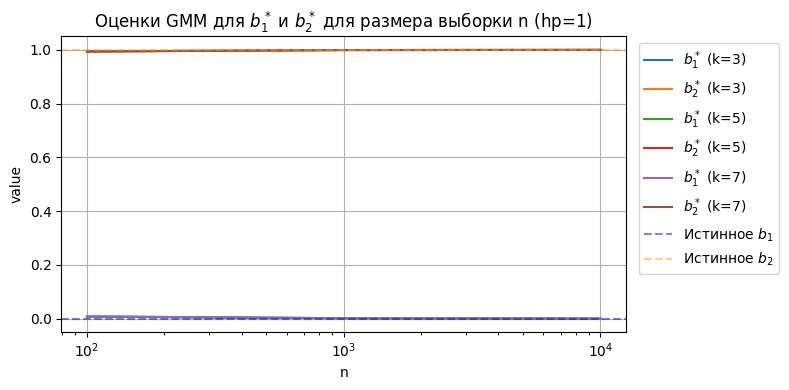

In [38]:
hp = hps[0]

plt.figure(figsize=(8, 4))

for k_val in ks:
    sub = (
        params_df[(params_df["k"] == k_val) & (params_df["hp"] == hp)]
        .sort_values("n")
        .groupby("n")
        .mean()
    )
    plt.plot(sizes, sub["b1"], label=f"$b_1^*$ (k={k_val})")
    plt.plot(sizes, sub["b2"], label=f"$b_2^*$ (k={k_val})")

plt.axhline(UNIFORM_LOW, color='blue', linestyle='--', alpha=0.5, label='Истинное $b_1$')
plt.axhline(UNIFORM_HIGH, color='orange', linestyle='--', alpha=0.5, label='Истинное $b_2$')
plt.xscale("log")
plt.xlabel("n")
plt.ylabel("value")
plt.title(f"Оценки GMM для $b_1^*$ и $b_2^*$ для размера выборки n ({hp=:d})")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid(True)

plt.tight_layout()
plt.show()

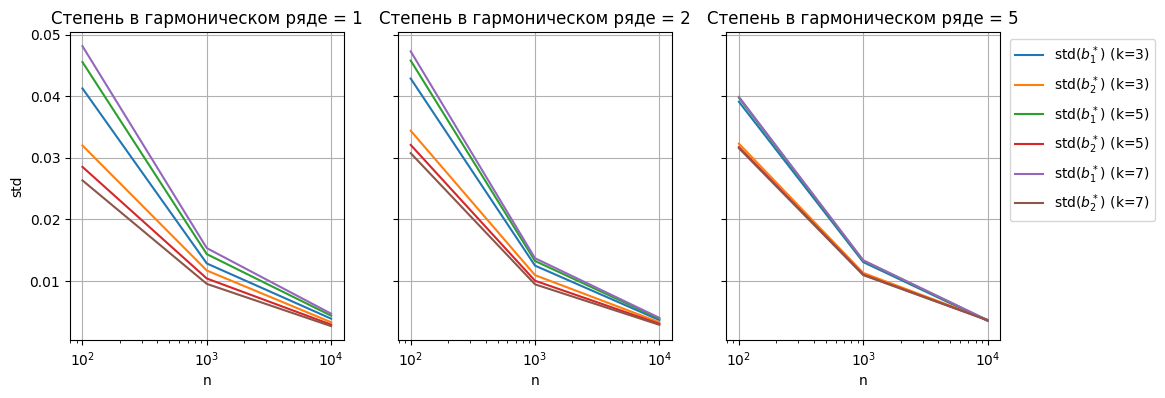

In [39]:
n = len(hps)
figsize = (4, 4)
fig, axs = plt.subplots(
    1, n, figsize=(figsize[0] * n, figsize[1]), squeeze=False, sharey=True
)

for i, hp in enumerate(hps):
    ax = axs[0, i]

    for k_val in ks:
        sub = (
            params_df[(params_df["k"] == k_val) & (params_df["hp"] == hp)]
            .sort_values("n")
            .groupby("n")
            .std()
        )
        ax.plot(sizes, sub["b1"], label=f"std($b_1^*$) (k={k_val})")
        ax.plot(sizes, sub["b2"], label=f"std($b_2^*$) (k={k_val})")

    ax.grid(True)
    ax.set_xscale("log")
    ax.set_xlabel("n")
    ax.set_title(f"Степень в гармоническом ряде = {hp:d}")

axs[0, -1].legend(bbox_to_anchor=(1.01, 1), loc="upper left")
axs[0, 0].set_ylabel("std")
plt.show()

## Метод моментов для экспоненциального распределения

Для экспоненциального распределения $X \sim \mathrm{Exp}_{\lambda}$

математическое ожидание:
$$
\mu_1 = \cfrac{1}{\lambda},
$$

тогда оценка параметра:
$$
\lambda^* = \cfrac{1}{\mu_1^*}
$$

In [5]:
def exponential_moments(sample):
    m1 = np.mean(sample)
    lambda_est = 1 / m1
    return lambda_est

In [ ]:
def experiment_exponential_mm(args):
    n, i = args
    sample = np.random.exponential(scale=1 / EXP_LAMBDA, size=n)
    lambda_est = exponential_moments(sample)
    return [n, lambda_est]

In [7]:
args_exponential = list(itertools.product(SAMPLE_SIZES, range(N_EXPERIMENTS)))
rs_exp = process_map(experiment_exponential_mm, args_exponential, chunksize=1)

100%|██████████| 7000/7000 [00:08<00:00, 781.52it/s] 


In [8]:
df_exp = pd.DataFrame(rs_exp, columns=("n", "lambda"))
df_exp

,n,lambda
0,10,1.037361
1,10,1.037361
2,10,1.037361
3,10,1.037361
4,10,1.037361
...,...,...
6995,10000,1.000305
6996,10000,0.987449
6997,10000,0.986387
6998,10000,0.997073


In [9]:
df_exp.to_csv("lab-3/exponential_mm_1.csv", index=False)

In [10]:
df_exp_mean = df_exp.groupby("n").mean()
df_exp_std = df_exp.groupby("n").std()
sizes_exp = df_exp["n"].unique()

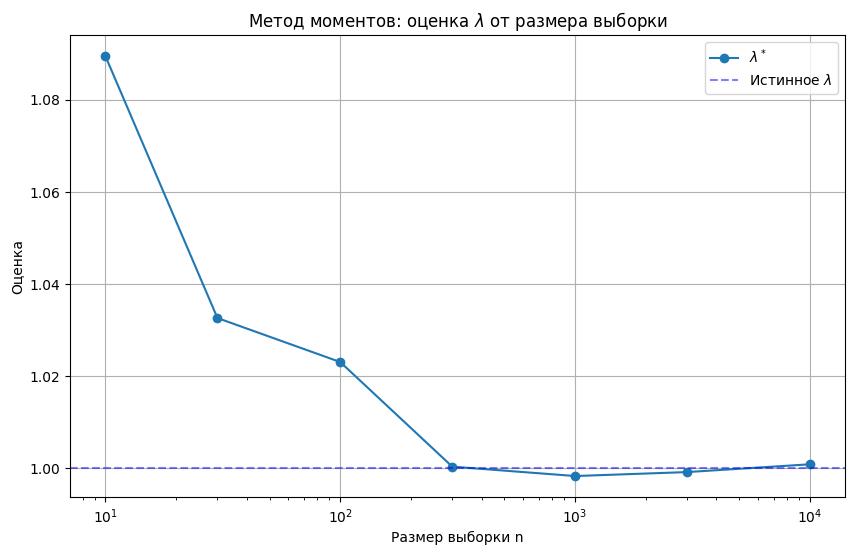

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(sizes_exp, df_exp_mean["lambda"], marker="o", label="$\lambda^*$")
plt.axhline(1.0, color="blue", linestyle="--", alpha=0.5, label="Истинное $\lambda$")
plt.xscale("log")
plt.xlabel("Размер выборки n")
plt.ylabel("Оценка")
plt.title("Метод моментов: оценка $\lambda$ от размера выборки")
plt.legend()
plt.grid(True)
plt.show()

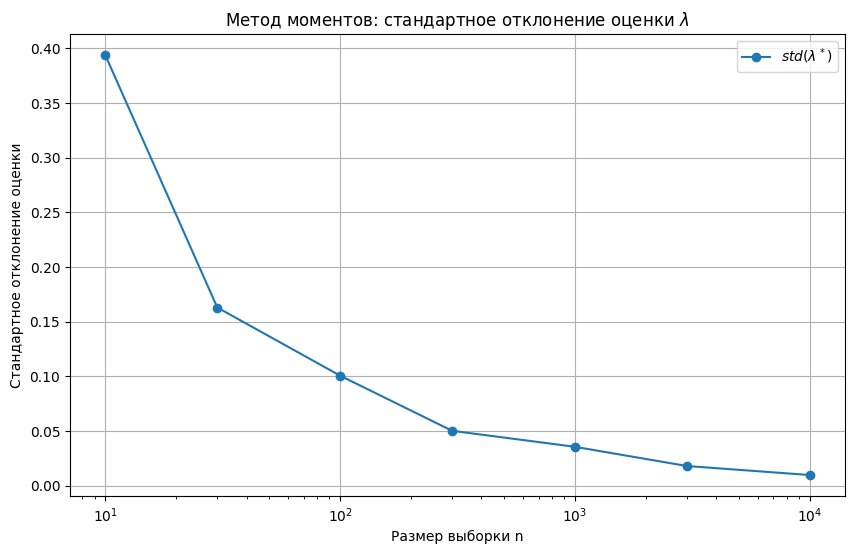

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(sizes_exp, df_exp_std["lambda"], marker="o", label="$std(\lambda^*)$")
plt.xscale("log")
plt.xlabel("Размер выборки n")
plt.ylabel("Стандартное отклонение оценки")
plt.title("Метод моментов: стандартное отклонение оценки $\lambda$")
plt.legend()
plt.grid(True)
plt.show()

### Обобщенный метод моментов

k-й момент:
$$
\mu_k = \cfrac{k!}{\lambda^k}
$$

In [ ]:
def factorials(k):
    return scipy.special.factorial(np.arange(1, k + 1))
    vals = [1]
    for i in range(2, k+1):
        vals.append(vals[-1] * i)
    return np.array(vals)

def exponential_gmm(sample, k, weights):
    sample_moments = np.array([np.mean(sample ** j) for j in range(1, k + 1)])

    def loss(params):
        lambda_param = params[0]
        if lambda_param <= 0:
            return 1e10
        lambda_pows = lambda_param ** np.arange(1, k + 1)
        exp_moments = factorials(k) / lambda_pows
        
        return np.sum(weights * (exp_moments - sample_moments) ** 2)

    init_params = [1 / np.mean(sample)]
    bounds_params = [(0.001, None)]
    # optimum = scipy.optimize.minimize(loss, init_params, method="BFGS")
    optimum = scipy.optimize.minimize(loss, init_params, method="L-BFGS-B", bounds=bounds_params)
    return optimum.x[0]

In [19]:
def experiment_exponential_gmm(args):
    (n, ks), hp, i = args
    sample = np.random.exponential(scale=1.0, size=n)
    params = [
        exponential_gmm(sample, k, weights=weights_harmonic(k, pow=hp))
        for k in ks
    ]
    return list(zip(ks, itertools.repeat(n), itertools.repeat(hp), params))

In [ ]:
exp_n_experiments = 100 # N_EXPERIMENTS
exponential_gmm_args = list(
    itertools.product(
        zip(SAMPLE_SIZES_GMM, itertools.repeat(K)), HARMONIC_POWS, range(exp_n_experiments)
    )
)
pss_exp = process_map(experiment_exponential_gmm, exponential_gmm_args, chunksize=1)

100%|██████████| 900/900 [02:03<00:00,  7.29it/s]


In [22]:
params_exp = [p for ps in pss_exp for p in ps]
params_df_exp = pd.DataFrame(params_exp, columns=("k", "n", "hp", "lambda"))
params_df_exp

,k,n,hp,lambda
0,3,100,0,1.128054
1,5,100,0,1.171027
2,7,100,0,1.238773
3,3,100,0,1.128054
4,5,100,0,1.171027
...,...,...,...,...
2695,5,10000,5,0.991112
2696,7,10000,5,0.987921
2697,3,10000,5,0.992807
2698,5,10000,5,0.992899


In [23]:
params_df_exp.to_csv("lab-3/exponential_gmm_hp.csv", index=False)

In [ ]:
params_df_exp = pd.read_csv("lab-3/exponential_gmm_hp.csv")

In [24]:
sizes_gmm = sorted(params_df_exp["n"].unique())
ks_exp = sorted(params_df_exp["k"].unique())
hps_exp = sorted(params_df_exp["hp"].unique())

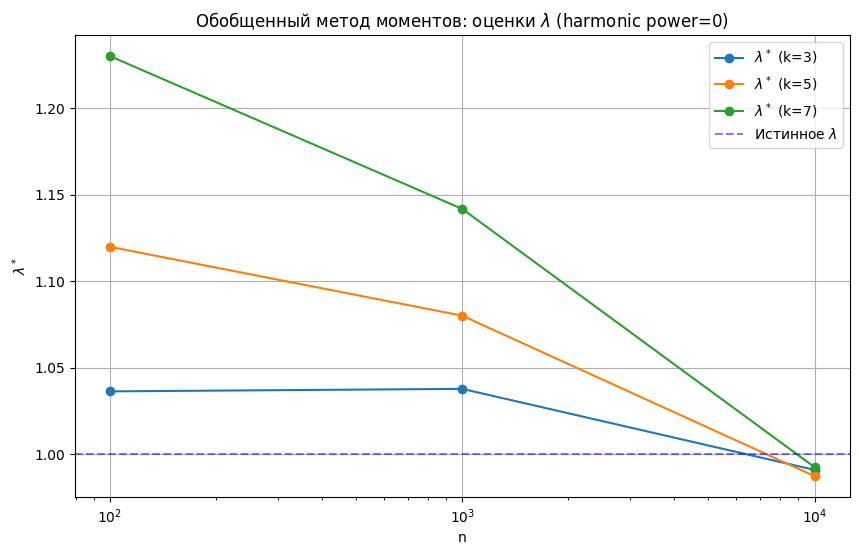

In [25]:
hp_val = hps_exp[0]
plt.figure(figsize=(10, 6))
for k_val in ks_exp:
    sub = (
        params_df_exp[(params_df_exp["k"] == k_val) & (params_df_exp["hp"] == hp_val)]
        .sort_values("n")
        .groupby("n")
        .mean()
    )
    plt.plot(sizes_gmm, sub["lambda"], marker="o", label=f"$\lambda^*$ (k={k_val})")

plt.axhline(1.0, color='blue', linestyle='--', alpha=0.5, label='Истинное $\lambda$')
plt.xscale("log")
plt.xlabel("n")
plt.ylabel("$\lambda^*$")
plt.title(f"Обобщенный метод моментов: оценки $\lambda$ (harmonic power={hp_val})")
plt.legend()
plt.grid(True)
plt.show()

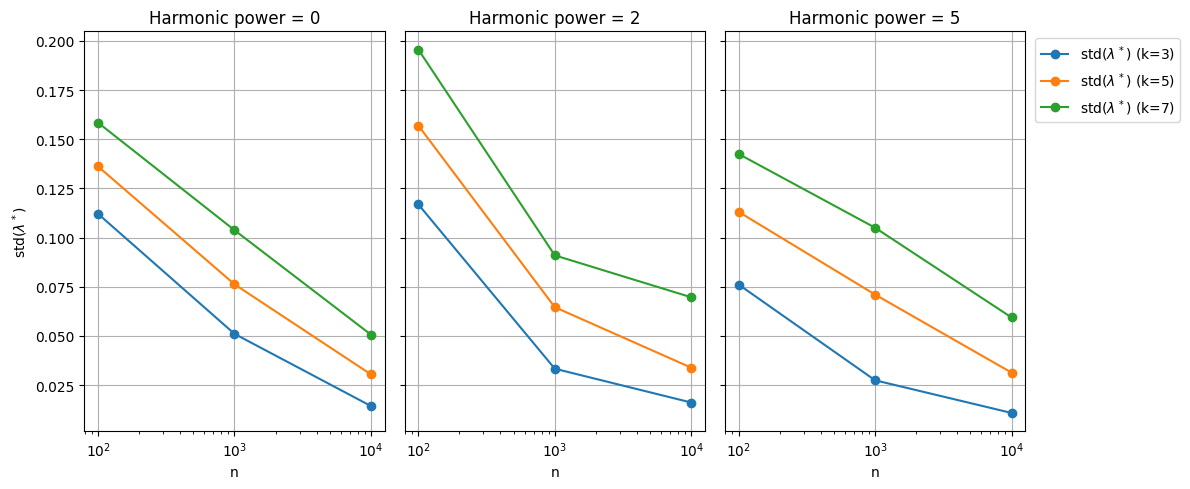

In [26]:
fig, axs = plt.subplots(
    1, len(hps_exp), figsize=(4 * len(hps_exp), 5), squeeze=False, sharey=True
)

for i, hp in enumerate(hps_exp):
    ax = axs[0, i]
    for k_val in ks_exp:
        sub = (
            params_df_exp[(params_df_exp["k"] == k_val) & (params_df_exp["hp"] == hp)]
            .sort_values("n")
            .groupby("n")
            .std()
        )
        ax.plot(sizes_gmm, sub["lambda"], marker="o", label=f"std($\lambda^*$) (k={k_val})")
    
    ax.grid(True)
    ax.set_xscale("log")
    ax.set_xlabel("n")
    ax.set_title(f"Harmonic power = {hp}")

axs[0, -1].legend(bbox_to_anchor=(1.01, 1), loc="upper left")
axs[0, 0].set_ylabel("std($\lambda^*$)")
plt.tight_layout()
plt.show()